# NBA ROLE PLAYER KNN ANALYSIS 

### IMPORTING DATA & LIBRARIES

In [1]:
# nba data
from nba_api.stats.endpoints import leagueleaders

# packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sn

# scikit
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import decomposition

In [2]:
# Pull data for the top 1000 scorers by PTS column
top_1000 = leagueleaders.LeagueLeaders(
    season='2022-23',
    season_type_all_star='Regular Season',
    stat_category_abbreviation='PTS'
).get_data_frames()[0][:1000]
top_1000

,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,FGA,FG_PCT,...,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
0,1628369,1,Jayson Tatum,1610612738,BOS,74,2732,727,1559,0.466,...,649,342,78,51,213,160,2225,2209,1.61,0.37
1,203954,2,Joel Embiid,1610612755,PHI,66,2284,728,1328,0.548,...,670,274,66,112,226,205,2183,2369,1.21,0.29
2,1629029,3,Luka Doncic,1610612742,DAL,66,2391,719,1449,0.496,...,569,529,90,33,236,166,2138,2214,2.24,0.38
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,2416,704,1381,0.510,...,329,371,112,65,192,192,2135,2073,1.93,0.58
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,2024,707,1278,0.553,...,742,359,52,51,246,197,1959,2072,1.46,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1631214,535,Alondes Williams,1610612751,BKN,1,5,0,0,0.000,...,1,0,0,0,2,1,0,-1,0.00,0.00
535,1629126,535,Deonte Burton,1610612758,SAC,2,7,0,2,0.000,...,0,0,0,0,0,0,0,-2,0.00,0.00
536,1628402,535,Frank Jackson,1610612762,UTA,1,5,0,3,0.000,...,2,1,0,0,0,0,0,0,0.00,0.00
537,1630701,535,Michael Foster Jr.,1610612755,PHI,1,1,0,0,0.000,...,0,0,0,0,0,0,0,0,0.00,0.00


In [3]:
top_1000.columns

Index(['PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'MIN', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'EFF',
       'AST_TOV', 'STL_TOV'],
      dtype='object')

### EDA

In [4]:
# make columns lowercase
top_1000.columns = map(str.lower, top_1000.columns)
top_1000.columns

Index(['player_id', 'rank', 'player', 'team_id', 'team', 'gp', 'min', 'fgm',
       'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov'],
      dtype='object')

In [5]:
# create per game averages
top_1000[['min', 'fgm',
       'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov']] = top_1000[['min', 'fgm',
       'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta', 'ft_pct',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts', 'eff',
       'ast_tov', 'stl_tov']].div(top_1000.gp, axis=0)
top_1000

,player_id,rank,player,team_id,team,gp,min,fgm,fga,fg_pct,...,reb,ast,stl,blk,tov,pf,pts,eff,ast_tov,stl_tov
0,1628369,1,Jayson Tatum,1610612738,BOS,74,36.918919,9.824324,21.067568,0.006297,...,8.770270,4.621622,1.054054,0.689189,2.878378,2.162162,30.067568,29.851351,0.021757,0.005000
1,203954,2,Joel Embiid,1610612755,PHI,66,34.606061,11.030303,20.121212,0.008303,...,10.151515,4.151515,1.000000,1.696970,3.424242,3.106061,33.075758,35.893939,0.018333,0.004394
2,1629029,3,Luka Doncic,1610612742,DAL,66,36.227273,10.893939,21.954545,0.007515,...,8.621212,8.015152,1.363636,0.500000,3.575758,2.515152,32.393939,33.545455,0.033939,0.005758
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.529412,10.352941,20.308824,0.007500,...,4.838235,5.455882,1.647059,0.955882,2.823529,2.823529,31.397059,30.485294,0.028382,0.008529
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.126984,11.222222,20.285714,0.008778,...,11.777778,5.698413,0.825397,0.809524,3.904762,3.126984,31.095238,32.888889,0.023175,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1631214,535,Alondes Williams,1610612751,BKN,1,5.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,-1.000000,0.000000,0.000000
535,1629126,535,Deonte Burton,1610612758,SAC,2,3.500000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
536,1628402,535,Frank Jackson,1610612762,UTA,1,5.000000,0.000000,3.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
537,1630701,535,Michael Foster Jr.,1610612755,PHI,1,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
# rename columns
top_1000_avg = top_1000.rename(columns={'min':'mpg', 'fgm':'fgm_pg',
       'fga':'fga_pg', 'fg_pct':'fg_pct_pg', 'fg3m':'fg3m_pg', 'fg3a':'fg3a_pg', 'fg3_pct':'fg3_pct_pg', 'ftm':'ftm_pg', 'fta':'fta_pg', 'ft_pct':'ft_pct_pg',
       'oreb':'oreb_pg', 'dreb':'dreb_pg', 'reb':'rpg', 'ast':'apg', 'stl':'spg', 'blk':'bpg', 'tov':'tov_pg', 'pf':'pf_pg', 'pts':'ppg', 'eff':'eff_pg',
       'ast_tov':'ast_tov_pg', 'stl_tov':'stl:tov_pg'})
top_1000_avg

,player_id,rank,player,team_id,team,gp,mpg,fgm_pg,fga_pg,fg_pct_pg,...,rpg,apg,spg,bpg,tov_pg,pf_pg,ppg,eff_pg,ast_tov_pg,stl:tov_pg
0,1628369,1,Jayson Tatum,1610612738,BOS,74,36.918919,9.824324,21.067568,0.006297,...,8.770270,4.621622,1.054054,0.689189,2.878378,2.162162,30.067568,29.851351,0.021757,0.005000
1,203954,2,Joel Embiid,1610612755,PHI,66,34.606061,11.030303,20.121212,0.008303,...,10.151515,4.151515,1.000000,1.696970,3.424242,3.106061,33.075758,35.893939,0.018333,0.004394
2,1629029,3,Luka Doncic,1610612742,DAL,66,36.227273,10.893939,21.954545,0.007515,...,8.621212,8.015152,1.363636,0.500000,3.575758,2.515152,32.393939,33.545455,0.033939,0.005758
3,1628983,4,Shai Gilgeous-Alexander,1610612760,OKC,68,35.529412,10.352941,20.308824,0.007500,...,4.838235,5.455882,1.647059,0.955882,2.823529,2.823529,31.397059,30.485294,0.028382,0.008529
4,203507,5,Giannis Antetokounmpo,1610612749,MIL,63,32.126984,11.222222,20.285714,0.008778,...,11.777778,5.698413,0.825397,0.809524,3.904762,3.126984,31.095238,32.888889,0.023175,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,1631214,535,Alondes Williams,1610612751,BKN,1,5.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,-1.000000,0.000000,0.000000
535,1629126,535,Deonte Burton,1610612758,SAC,2,3.500000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
536,1628402,535,Frank Jackson,1610612762,UTA,1,5.000000,0.000000,3.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
537,1630701,535,Michael Foster Jr.,1610612755,PHI,1,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# remove irrelevant cols
top_1000_avg = top_1000_avg.drop(columns = ['player_id','rank','team_id'])
top_1000_avg

,player,team,gp,mpg,fgm_pg,fga_pg,fg_pct_pg,fg3m_pg,fg3a_pg,fg3_pct_pg,...,rpg,apg,spg,bpg,tov_pg,pf_pg,ppg,eff_pg,ast_tov_pg,stl:tov_pg
0,Jayson Tatum,BOS,74,36.918919,9.824324,21.067568,0.006297,3.243243,9.270270,0.004730,...,8.770270,4.621622,1.054054,0.689189,2.878378,2.162162,30.067568,29.851351,0.021757,0.005000
1,Joel Embiid,PHI,66,34.606061,11.030303,20.121212,0.008303,1.000000,3.030303,0.005000,...,10.151515,4.151515,1.000000,1.696970,3.424242,3.106061,33.075758,35.893939,0.018333,0.004394
2,Luka Doncic,DAL,66,36.227273,10.893939,21.954545,0.007515,2.803030,8.196970,0.005182,...,8.621212,8.015152,1.363636,0.500000,3.575758,2.515152,32.393939,33.545455,0.033939,0.005758
3,Shai Gilgeous-Alexander,OKC,68,35.529412,10.352941,20.308824,0.007500,0.852941,2.470588,0.005074,...,4.838235,5.455882,1.647059,0.955882,2.823529,2.823529,31.397059,30.485294,0.028382,0.008529
4,Giannis Antetokounmpo,MIL,63,32.126984,11.222222,20.285714,0.008778,0.746032,2.714286,0.004365,...,11.777778,5.698413,0.825397,0.809524,3.904762,3.126984,31.095238,32.888889,0.023175,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Alondes Williams,BKN,1,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,-1.000000,0.000000,0.000000
535,Deonte Burton,SAC,2,3.500000,0.000000,1.000000,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
536,Frank Jackson,UTA,1,5.000000,0.000000,3.000000,0.000000,0.000000,1.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
537,Michael Foster Jr.,PHI,1,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
# filter for 'role players' -> define role players as players playing 10<mpg<34 & avging <23 ppg (as per 6moty) 
role_players_2022 = top_1000_avg[(top_1000_avg['mpg'] < 30) & (top_1000_avg['mpg'] > 10) & (top_1000_avg['ppg'] < 23) & (top_1000_avg['gp'] > 35)]
role_players_2022

,player,team,gp,mpg,fgm_pg,fga_pg,fg_pct_pg,fg3m_pg,fg3a_pg,fg3_pct_pg,...,rpg,apg,spg,bpg,tov_pg,pf_pg,ppg,eff_pg,ast_tov_pg,stl:tov_pg
18,Jordan Poole,GSW,82,29.975610,6.707317,15.585366,0.005244,2.609756,7.768293,0.004098,...,2.743902,4.500000,0.768293,0.256098,3.073171,2.609756,20.426829,16.085366,0.017805,0.003049
49,Bennedict Mathurin,IND,78,28.487179,5.294872,12.192308,0.005564,1.282051,3.974359,0.004141,...,4.076923,1.487179,0.615385,0.166667,1.948718,2.076923,16.692308,13.192308,0.009744,0.004103
64,Immanuel Quickley,NYK,81,28.938272,5.172840,11.555556,0.005531,2.074074,5.604938,0.004568,...,4.160494,3.444444,0.987654,0.172840,1.234568,2.049383,14.925926,15.518519,0.034444,0.009877
68,Jaren Jackson Jr.,MEM,63,28.380952,6.603175,13.047619,0.008032,1.587302,4.476190,0.005635,...,6.761905,0.952381,1.031746,3.000000,1.698413,3.603175,18.619048,21.190476,0.008889,0.009683
71,Russell Westbrook,LAC,73,29.123288,5.917808,13.575342,0.005973,1.219178,3.917808,0.004260,...,5.794521,7.547945,1.041096,0.452055,3.493151,2.219178,15.876712,18.082192,0.029589,0.004110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,Damian Jones,UTA,41,11.634146,1.341463,2.097561,0.015610,0.243902,0.414634,0.014341,...,2.975610,0.365854,0.195122,0.512195,0.560976,1.341463,3.463415,6.024390,0.015854,0.008537
393,Frank Ntilikina,DAL,47,12.936170,1.021277,2.808511,0.007745,0.361702,1.425532,0.005404,...,1.319149,1.234043,0.340426,0.148936,0.617021,1.382979,2.872340,3.276596,0.042553,0.011702
397,Max Christie,LAL,41,12.487805,1.073171,2.585366,0.010122,0.634146,1.512195,0.010220,...,1.829268,0.512195,0.219512,0.170732,0.317073,0.804878,3.121951,3.975610,0.039268,0.016829
400,Juancho Hernangomez,TOR,42,14.619048,1.142857,2.714286,0.010024,0.404762,1.595238,0.006048,...,2.928571,0.595238,0.380952,0.142857,0.357143,1.023810,2.904762,4.857143,0.039762,0.025476


In [9]:
# reset index and drop gp column
role_players_2022 = role_players_2022.sort_values(by='player').drop(['gp'],axis=1).reset_index(drop=True)
role_players_2022

,player,team,mpg,fgm_pg,fga_pg,fg_pct_pg,fg3m_pg,fg3a_pg,fg3_pct_pg,ftm_pg,...,rpg,apg,spg,bpg,tov_pg,pf_pg,ppg,eff_pg,ast_tov_pg,stl:tov_pg
0,AJ Griffin,ATL,19.458333,3.444444,7.402778,0.006458,1.402778,3.597222,0.005417,0.583333,...,2.125000,1.013889,0.583333,0.166667,0.583333,1.208333,8.875000,8.152778,0.024167,0.013889
1,Aaron Holiday,ATL,13.412698,1.460317,3.492063,0.006635,0.571429,1.396825,0.006492,0.428571,...,1.174603,1.412698,0.587302,0.190476,0.571429,1.253968,3.920635,4.603175,0.039206,0.016349
2,Aaron Nesmith,IND,24.876712,3.452055,8.082192,0.005849,1.575342,4.301370,0.005014,1.630137,...,3.794521,1.342466,0.753425,0.465753,1.027397,3.219178,10.109589,10.493151,0.017945,0.010000
3,Aaron Wiggins,OKC,18.528571,2.657143,5.185714,0.007314,0.685714,1.742857,0.005614,0.842857,...,3.000000,1.142857,0.557143,0.214286,0.785714,1.571429,6.842857,8.271429,0.020857,0.010143
4,Admiral Schofield,ORL,12.189189,1.486486,3.297297,0.012189,0.648649,2.000000,0.008757,0.567568,...,1.675676,0.837838,0.216216,0.135135,0.432432,1.648649,4.189189,4.756757,0.052432,0.013514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Xavier Tillman,MEM,19.344262,3.081967,5.016393,0.010066,0.065574,0.245902,0.004377,0.803279,...,5.032787,1.573770,0.950820,0.475410,0.721311,1.590164,7.032787,11.754098,0.035738,0.021639
257,Yuta Watanabe,BKN,16.000000,1.965517,4.000000,0.008466,1.034483,2.327586,0.007655,0.586207,...,2.431034,0.827586,0.431034,0.293103,0.379310,1.379310,5.551724,6.896552,0.037586,0.019655
258,Zach Collins,SAS,22.873016,4.507937,8.698413,0.008222,0.873016,2.333333,0.005937,1.714286,...,6.380952,2.857143,0.587302,0.777778,2.047619,3.158730,11.603175,15.428571,0.022222,0.004603
259,Zeke Nnaji,DEN,13.735849,2.075472,3.698113,0.010585,0.320755,1.226415,0.004943,0.754717,...,2.603774,0.339623,0.320755,0.433962,0.584906,1.981132,5.226415,6.301887,0.010943,0.010377


In [10]:
# create new dataframe with player names only then drop in other dataframe so that kmeans can be performed
names_teams = role_players_2022[['player','team']]
names_teams

,player,team
0,AJ Griffin,ATL
1,Aaron Holiday,ATL
2,Aaron Nesmith,IND
3,Aaron Wiggins,OKC
4,Admiral Schofield,ORL
...,...,...
256,Xavier Tillman,MEM
257,Yuta Watanabe,BKN
258,Zach Collins,SAS
259,Zeke Nnaji,DEN


In [11]:
# dropping more columns
role_players_2022 = role_players_2022.drop(['team','player','mpg','fg_pct_pg','fg3_pct_pg','ft_pct_pg','eff_pg','rpg'],axis=1)
role_players_2022

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,dreb_pg,apg,spg,bpg,tov_pg,pf_pg,ppg,ast_tov_pg,stl:tov_pg
0,3.444444,7.402778,1.402778,3.597222,0.583333,0.652778,0.513889,1.611111,1.013889,0.583333,0.166667,0.583333,1.208333,8.875000,0.024167,0.013889
1,1.460317,3.492063,0.571429,1.396825,0.428571,0.507937,0.396825,0.777778,1.412698,0.587302,0.190476,0.571429,1.253968,3.920635,0.039206,0.016349
2,3.452055,8.082192,1.575342,4.301370,1.630137,1.945205,0.849315,2.945205,1.342466,0.753425,0.465753,1.027397,3.219178,10.109589,0.017945,0.010000
3,2.657143,5.185714,0.685714,1.742857,0.842857,1.014286,0.971429,2.028571,1.142857,0.557143,0.214286,0.785714,1.571429,6.842857,0.020857,0.010143
4,1.486486,3.297297,0.648649,2.000000,0.567568,0.621622,0.621622,1.054054,0.837838,0.216216,0.135135,0.432432,1.648649,4.189189,0.052432,0.013514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,3.081967,5.016393,0.065574,0.245902,0.803279,1.459016,1.983607,3.049180,1.573770,0.950820,0.475410,0.721311,1.590164,7.032787,0.035738,0.021639
257,1.965517,4.000000,1.034483,2.327586,0.586207,0.810345,0.517241,1.913793,0.827586,0.431034,0.293103,0.379310,1.379310,5.551724,0.037586,0.019655
258,4.507937,8.698413,0.873016,2.333333,1.714286,2.253968,1.841270,4.539683,2.857143,0.587302,0.777778,2.047619,3.158730,11.603175,0.022222,0.004603
259,2.075472,3.698113,0.320755,1.226415,0.754717,1.169811,1.226415,1.377358,0.339623,0.320755,0.433962,0.584906,1.981132,5.226415,0.010943,0.010377


In [12]:
# split to offensive and defensive dfs


In [13]:
role_players_2022.columns

Index(['fgm_pg', 'fga_pg', 'fg3m_pg', 'fg3a_pg', 'ftm_pg', 'fta_pg', 'oreb_pg',
       'dreb_pg', 'apg', 'spg', 'bpg', 'tov_pg', 'pf_pg', 'ppg', 'ast_tov_pg',
       'stl:tov_pg'],
      dtype='object')

### Preprocessing

In [14]:
# identify numeric features
numeric_features = role_players_2022.columns.tolist()

# create numeric transformer
numeric_transformer = StandardScaler()

# create column transformer
scaler = make_column_transformer((numeric_transformer,numeric_features))

# scale data
scale = scaler.fit_transform(role_players_2022)


# to df
nba_rp_scaled = pd.DataFrame(scale, columns = numeric_features)
nba_rp_scaled

,fgm_pg,fga_pg,fg3m_pg,fg3a_pg,ftm_pg,fta_pg,oreb_pg,dreb_pg,apg,spg,bpg,tov_pg,pf_pg,ppg,ast_tov_pg,stl:tov_pg
0,0.328221,0.390093,0.697370,0.570165,-0.737794,-0.899763,-0.581918,-0.812220,-0.606220,-0.087462,-0.630078,-0.824178,-1.014346,0.205989,-0.406219,0.309112
1,-1.254583,-1.132860,-0.561872,-0.734318,-0.935086,-1.045919,-0.729765,-1.416728,-0.284058,-0.074154,-0.570927,-0.847968,-0.937399,-1.242537,0.551346,0.670198
2,0.334292,0.654678,0.958754,0.987612,0.596684,0.404391,-0.158287,0.155546,-0.340793,0.482946,0.112963,0.063205,2.376225,0.566950,-0.802334,-0.261636
3,-0.299836,-0.473300,-0.388764,-0.529176,-0.406950,-0.534975,-0.004063,-0.509390,-0.502038,-0.175292,-0.511775,-0.419756,-0.402115,-0.388156,-0.616934,-0.240669
4,-1.233708,-1.208708,-0.444907,-0.376732,-0.757892,-0.931202,-0.445856,-1.216314,-0.748435,-1.318603,-0.708414,-1.125727,-0.271911,-1.164019,1.393441,0.254021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0.039061,-0.539238,-1.328089,-1.416631,-0.457405,-0.086209,1.274279,0.230970,-0.153943,1.144918,0.136953,-0.548453,-0.370525,-0.332626,0.330500,1.446598
257,-0.851569,-0.935054,0.139515,-0.182526,-0.734131,-0.740767,-0.577684,-0.592651,-0.756716,-0.598202,-0.315963,-1.231882,-0.726054,-0.765650,0.448193,1.155394
258,1.176605,0.894654,-0.105059,-0.179119,0.703958,0.715955,1.094513,1.312195,0.882775,-0.074154,0.888146,2.101937,2.274302,1.003636,-0.530020,-1.053694
259,-0.763854,-1.052618,-0.941567,-0.835344,-0.519312,-0.378039,0.317975,-0.981786,-1.150897,-0.968029,0.033982,-0.821036,0.288703,-0.860762,-1.248134,-0.206253


### Elbow Method

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

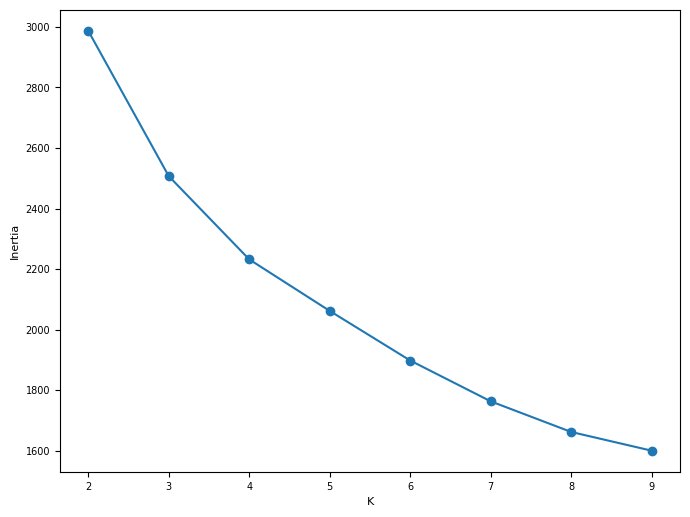

In [15]:
def plot_elbow(w, h, inertia_values):
    plt.figure(figsize=(w, h))
    plt.plot(range(2, 10), inertia_values, "-o")
    ax = plt.gca()
    ax.tick_params("both", labelsize=(w + h) / 2)
    ax.set_xlabel("K", fontsize=w)
    ax.set_ylabel("Inertia", fontsize=w)
    
inertia_values = list()
for k in range(2, 10):
    inertia_values.append(KMeans(n_clusters=k).fit(nba_rp_scaled).inertia_)
plot_elbow(8, 6, inertia_values)

### Silhouette Method

In [16]:
for i in range(2,10):
    labels=cluster.KMeans(n_clusters=i,random_state=200).fit(nba_rp_scaled).labels_
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
    +str(metrics.silhouette_score(nba_rp_scaled,labels,metric="euclidean",sample_size=1000,random_state=200)))

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 2 is 0.26990955024019636
Silhouette score for k(clusters) = 3 is 0.27017753978879816


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Silhouette score for k(clusters) = 4 is 0.19566033642933292
Silhouette score for k(clusters) = 5 is 0.17167688402590692


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Silhouette score for k(clusters) = 6 is 0.18097095633731372
Silhouette score for k(clusters) = 7 is 0.16357693774860452


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

Silhouette score for k(clusters) = 8 is 0.16715081775167923


C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Silhouette score for k(clusters) = 9 is 0.17047269223043926


#### pick value of 6 for k

### KNN with PCA to decrease dimensionality

In [17]:
# PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(nba_rp_scaled)
pca_rp_df = pd.DataFrame(data=principalComponents,
                         columns = ['PC1','PC2'])


pca_rp_df

# kmeans with principal components
kmeans_rp = KMeans(random_state=22, n_clusters=6)
kmeans_fit = kmeans_rp.fit(pca_rp_df)

# add predictions to dataframe
pca_rp_df["cluster"] = kmeans_rp.labels_
pca_rp_df

C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\17782\miniconda3\envs\machine_learning\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


,PC1,PC2,cluster
0,-1.098576,-1.401017,5
1,-3.388994,-0.317129,3
2,1.924086,-0.260553,0
3,-1.300268,0.419447,3
4,-3.401569,-0.125744,3
...,...,...,...
256,-0.921669,1.552888,1
257,-2.735174,-0.333486,3
258,3.787513,1.406984,2
259,-2.075957,1.770983,1


In [23]:
# get variance explained by principle components
print(pca.explained_variance_ratio_.round(2)[:10])

[0.43 0.22]


In [18]:
# create final dataframe to visualize
nba_rp_final_df = pd.concat([names_teams,pca_rp_df], axis=1)
nba_rp_final_df

,player,team,PC1,PC2,cluster
0,AJ Griffin,ATL,-1.098576,-1.401017,5
1,Aaron Holiday,ATL,-3.388994,-0.317129,3
2,Aaron Nesmith,IND,1.924086,-0.260553,0
3,Aaron Wiggins,OKC,-1.300268,0.419447,3
4,Admiral Schofield,ORL,-3.401569,-0.125744,3
...,...,...,...,...,...
256,Xavier Tillman,MEM,-0.921669,1.552888,1
257,Yuta Watanabe,BKN,-2.735174,-0.333486,3
258,Zach Collins,SAS,3.787513,1.406984,2
259,Zeke Nnaji,DEN,-2.075957,1.770983,1


In [24]:
rp_kmeans_graph = alt.Chart(nba_rp_final_df,title= 'NBA Role Player Kmeans Clustering').mark_point(
).encode(alt.X('PC1',title ='Principle Component 1 (43%)'),
         alt.Y('PC2',title = 'Principle Component 2 (22%)'),
         alt.Color('cluster:N'),
         tooltip= [alt.Tooltip('player'),
                   alt.Tooltip('team')])

rp_kmeans_graph

alt.Chart(...)

In [25]:
# get variable contributions to principle components
weights = abs(pca.components_)
weights

array([[0.36152187, 0.33944498, 0.12251336, 0.1259855 , 0.3201581 ,
        0.32515635, 0.13955774, 0.25576512, 0.20039002, 0.17260132,
        0.15055566, 0.31938143, 0.2582843 , 0.36207472, 0.10608755,
        0.1624648 ],
       [0.04705857, 0.20221738, 0.42394833, 0.43439152, 0.02246033,
        0.10353322, 0.42150312, 0.266663  , 0.22957113, 0.14120436,
        0.3564882 , 0.04037851, 0.20138451, 0.11117566, 0.25599723,
        0.09306793]])

In [ ]:
# correlaton matrix for components
corr_matr = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
